## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

## On entraîne le modèle sur tous les pixels
### Permet de visualiser les dimensions de la carte latente

In [1]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import keras
import os
import re



In [2]:
# Fonction pour calculer les coordonées stéréographiques

def stereo(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Projection sur x y
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

# Importation des images

In [5]:
# Dossier contenant les images
repertoire = "../Render/captures_bleu"
img_width, img_height = 30, 30

# Expression pour extraire les infos du nom de fichier
#pattern = re.compile(r"img_tv(\d+)_pv(\d+)_tl(\d+)_pl(\d+)\.png") #all
pattern = re.compile(r"img_tv0_pv0_tl(\d+)_pl(\d+)\.jpg") #les images avec tv = 45 (la latitude moyenne)

# Stockage des résultats
images_info = []

for nom_fichier in os.listdir(repertoire):
    if nom_fichier.endswith(".jpg"):
        match = pattern.match(nom_fichier)
        if match:
            tl, pl = match.groups()
            tl, pl = int(tl), int(pl)
            px, py = stereo(np.radians(tl), np.radians(pl)) # Calcul des coordonnées stéréo
            chemin_image = os.path.join(repertoire, nom_fichier)
            image = Image.open(chemin_image)
            w, h = image.size
            left = (w - img_width) / 2
            top = (h - img_height) / 2
            right = (w + img_width) / 2
            bottom = (h + img_height) / 2
            #left, top, right, bottom = int(left), int(top), int(right), int(bottom)
            image = Image.open(chemin_image).crop((left, top, right, bottom))
            pixels = np.array(image, dtype=np.float32) / 255.0


            images_info.append({
                "tl": tl,
                "pl": pl,
                "px": px,
                "py": py,
                "image": image,
                "pixels": pixels,
            })

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}")

tl=75, pl=345, px=0.7411809490095723, py=-0.198598836732448
tl=75, pl=225, px=-0.5425821122771244, py=-0.5425821122771243
tl=60, pl=252, px=-0.17841104369713806, py=-0.5490927320369364
tl=30, pl=120, px=-0.13397459549759358, py=0.23205080632532074
tl=45, pl=160, px=-0.3892334257113643, py=0.14166938114040184


In [6]:
images_info[2]['image']

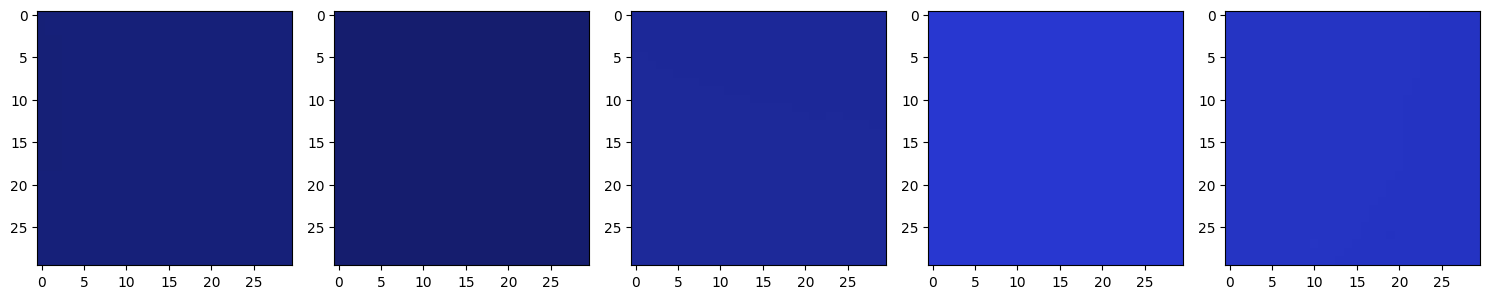

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [8]:
sorted = copy.deepcopy(images_info)
sorted.sort(key=lambda d: (d["tl"], d["pl"]))

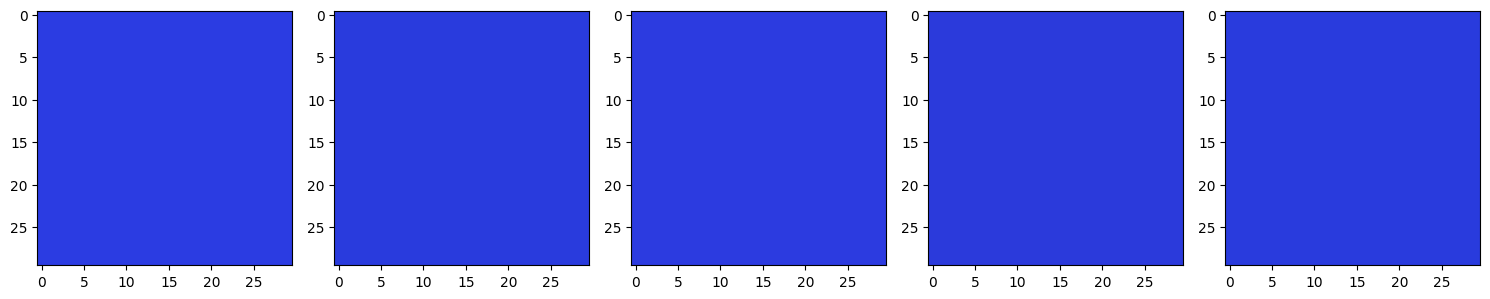

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(sorted[i]['pixels'])
plt.tight_layout()
plt.show()

In [21]:
images_info.sort(key=lambda d: (d["tl"], d["pl"]))
images_info[0]['pixels'][0, 0]

# 0.16862746, 0.23529412, 0.8862745 -> theta phi
# 0.09019608, 0.12156863, 0.45490196 -> stereo

array([0.16862746, 0.23529412, 0.8862745 ], dtype=float32)

In [22]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [0.17254902 0.23137255 0.8784314 ]
Nombre d'images importées: 81


# Création du modèles

In [23]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (samples, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1
x = Conv1D(filters = 64, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x) #weight decay
x = MaxPooling1D(pool_size=2)(x)

# Bloc 2
x = Conv1D(filters = 128, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 3
x = Conv1D(filters = 256, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 4
x = Conv1D(filters = 512, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)


# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder = Model(inputs=i, outputs=latent_output, name="Encoder")
encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 81, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 81, 512)        │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 81, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_output (Dense)           │ (None, 8)              │       163,848 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,016 (668.03 KB)

 Trainable params: 169,992 (664.03 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [24]:
# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input = Input(shape=(input_dim,), name='decoder_input')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder")
decoder_model.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 106)            │         1,166 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rgb_output (Dense)              │ (None, 3)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,513 (138.72 KB)

 Trainable params: 35,513 (138.72 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# =================
# Modele
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder(i)
decoder_input = Concatenate()([latent_vector, view_light_input])
model_outputs = decoder_model(decoder_input)

model = Model(inputs=[i, view_light_input], outputs=model_outputs, name='Modele')
model.summary()

Model: "Modele"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 81, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 8)         │    171,016 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 10)        │          0 │ Encoder[0][0],    │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 3)         │     35,513 │ concatenate_1[0]… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 206,529 (806.75 KB)

 Trainable params: 205,505 (802.75 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [26]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Compilation et entraînement
Sur un seul texel pour commencer

In [27]:
# on prend toutes les images
image_stack = np.stack([info["pixels"] for info in images_info], axis=0)
# image_stack.shape = (N_images, height, width, 3)

In [28]:
# on fait de même avec les angles
tl_stack = np.stack([info["tl"] for info in images_info], axis=0)
pl_stack = np.stack([info["pl"] for info in images_info], axis=0)

# et pour les positions stéréo
px_stack = np.stack([info["px"] for info in images_info], axis=0)
py_stack = np.stack([info["py"] for info in images_info], axis=0)

In [29]:
# Préparation des données

# On prend toutes les ABRDF par texel
num_pixels = img_height*img_width
image_stack_flat = image_stack.reshape((samples, num_pixels, num_channels))

texel_observations = np.zeros((num_pixels, samples, num_channels))
texel_observations = np.transpose(image_stack_flat, (1, 0, 2)) # Pour avoir les informations par pixel, on inverse juste les axes
print("Nouvelle forme:", texel_observations.shape)

Nouvelle forme: (900, 81, 3)


In [30]:
light_dirs = np.stack([px_stack, py_stack], axis=1) # Forme (81, 2)
rep_light_dirs = np.tile(light_dirs, (num_pixels, 1, 1))
target_rgb_train = texel_observations  # (900, 81, 3)

texel_observations.shape, rep_light_dirs.shape, target_rgb_train.shape

((900, 81, 3), (900, 81, 2), (900, 81, 3))

In [31]:
reshaped_input = np.repeat(texel_observations, samples, axis=0)
# Nouvelle forme: (num_pixels * samples, 81, 3)

reshaped_light_dirs = rep_light_dirs.reshape(-1, 2)
# Nouvelle forme: (num_pixels * samples, 2)

reshaped_target_rgb = target_rgb_train.reshape(-1, 3)
# Nouvelle forme: (num_pixels * samples, 3)

reshaped_input.shape, reshaped_light_dirs.shape, reshaped_target_rgb.shape

((72900, 81, 3), (72900, 2), (72900, 3))

# Entraînement du modèle

In [32]:
custom_optimizer = Adam(learning_rate=0.001) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
model.compile(custom_optimizer, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history = model.fit(
    [reshaped_input, reshaped_light_dirs], # Keras gère le batch_size automatiquement
    reshaped_target_rgb,
    epochs=30,
    batch_size=5, # Keras va prendre 5 pixels à la fois et les passer à l'encodeur/décodeur
    validation_split=0.2
)


Epoch 1/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - loss: 0.0025 - val_loss: 2.3174e-05
Epoch 2/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - loss: 4.1108e-05 - val_loss: 9.0756e-06
Epoch 3/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 9.5479e-06 - val_loss: 5.5019e-06
Epoch 4/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 1.1109e-05 - val_loss: 6.3008e-06
Epoch 5/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 8.7507e-06 - val_loss: 4.2971e-06
Epoch 6/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 1.2999e-05 - val_loss: 4.2160e-06
Epoch 7/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 6.0851e-06 - val_loss: 5.4311e-06
Epoch 8/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 4.3503e-06 - val_loss: 6.8741e-06
Epoch 9/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - loss: 3.9122e-06 - val_loss: 3.0789e-06
Epoch 10/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 6.3810e-06 - val_loss: 5.9615e-06
Epoch 11/30
1

dict_keys(['loss', 'val_loss'])


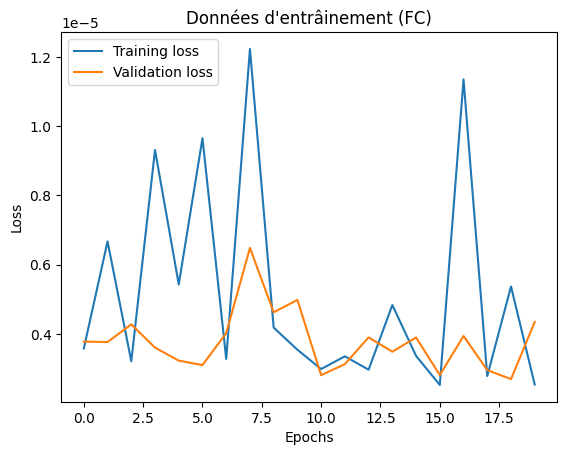

In [33]:
# Evaluer l'apprentissage d'un modèle --Code: Patrick Reuter--
def montrerCourbesApprentissage(history):
    #list all data in history
    print(history.history.keys())

    plt.plot(history.history['loss'][10:], label="Training loss")
    plt.plot(history.history['val_loss'][10:], label="Validation loss")

    plt.title("Données d'entrâinement (FC)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

montrerCourbesApprentissage(history)

# On enregistre le modèle

enco_save_path = os.path.join('modeles/', 'my_enco_bleu.keras')
encoder.save(enco_save_path)

deco_save_path = os.path.join('modeles/', 'my_deco_bleu.keras')
decoder_model.save(deco_save_path)

# On le charge, si il est déjà entraîné

In [35]:
enco_save_path = os.path.join('modeles/', 'my_enco_bleu.keras')
deco_save_path = os.path.join('modeles/', 'my_deco_bleu.keras')

pre = keras.models.load_model(enco_save_path)
post = keras.models.load_model(deco_save_path)

# Prédicitions sur un pixel

In [40]:
lum_index = 3
pixel_index = 0
light_direction =light_dirs[lum_index]

latent_vector = pre.predict(reshaped_input)[pixel_index]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = post.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train[pixel_index, lum_index])

2279/2279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted RGB: [[0.16867885 0.22668445 0.85581434]] Original [0.16862746 0.22745098 0.85882354]


# Génération de la carte latente

In [41]:
encoder_input_for_all_pixels = texel_observations # Shape: (num_pixels, 81, 3)

# L'encodeur prendra (num_pixels, 81, 3) et produira (num_pixels, latent_dim)
all_latent_vectors = pre.predict(encoder_input_for_all_pixels, verbose=1)
latent_map = all_latent_vectors.reshape((img_height, img_width, latent_dim))
print(f"Forme de la carte latente: {latent_map.shape}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Forme de la carte latente: (30, 30, 8)


In [42]:
def show_comparaison(latent_map, decoder_model, light_direction_2d, ground_truth_image):
    H, W, latent_dim = latent_map.shape
    num_pixels = H * W

    # Préparer l'entrée du décodeur pour tous les pixels
    latent_flat = latent_map.reshape(-1, latent_dim)  # (H*W, latent_dim)

    # Répéter la direction de lumière pour qu'elle corresponde à chaque pixel
    light_dir_repeated = np.repeat(light_direction_2d[np.newaxis, :], num_pixels, axis=0)

    # Concaténer le vecteur latent de chaque pixel avec la direction de lumière répétée
    decoder_input_combined = np.concatenate([latent_flat, light_dir_repeated], axis=1) # (H*W, latent_dim + angle_dim)


    # Prédiction par le décodeur
    predicted_rgb_flat = post.predict(decoder_input_combined, verbose=0)  # (H*W, 3)
    predicted_image = predicted_rgb_flat.reshape(H, W, 3) # (H, W, 3)

    # Calcul de la différence absolue
    mse = np.mean(np.square(predicted_image - ground_truth_image))

    
    # Normalisation pour l'affichage et affichage
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    display_predicted = np.clip(predicted_image, 0, 1)
    display_ground_truth = np.clip(ground_truth_image, 0, 1)
    
    # Affichage des images
    axs[0].imshow(display_predicted)
    axs[0].set_title("Image prédite")
    axs[0].axis('off')

    axs[1].imshow(display_ground_truth)
    axs[1].set_title("Image réelle")
    axs[1].axis('off')

    axs[2].axis('off')
    axs[2].text(0.5, 0.5, f"MSE: {mse:.5f}", horizontalalignment='center', verticalalignment='center', fontsize=18, color='black', transform=axs[2].transAxes)
    axs[2].set_title("Erreur de Reconstruction")

    plt.tight_layout()
    plt.show()

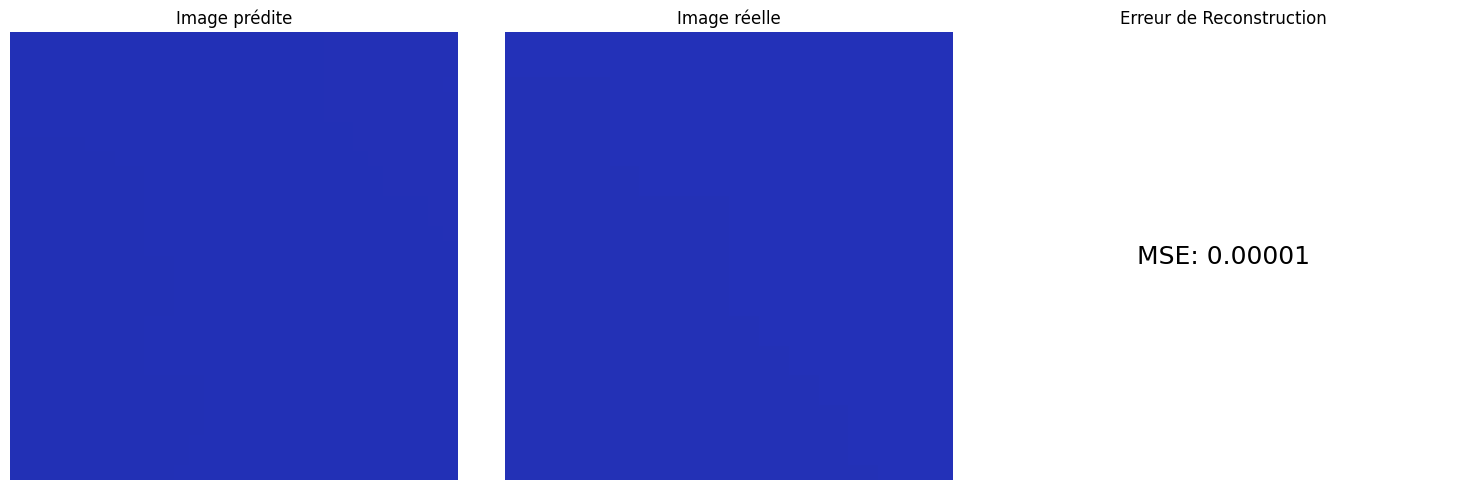

In [54]:
config = 21

angle_to_predict = light_dirs[config]
base_image = image_stack[config]

show_comparaison(latent_map, decoder_model, angle_to_predict, base_image)

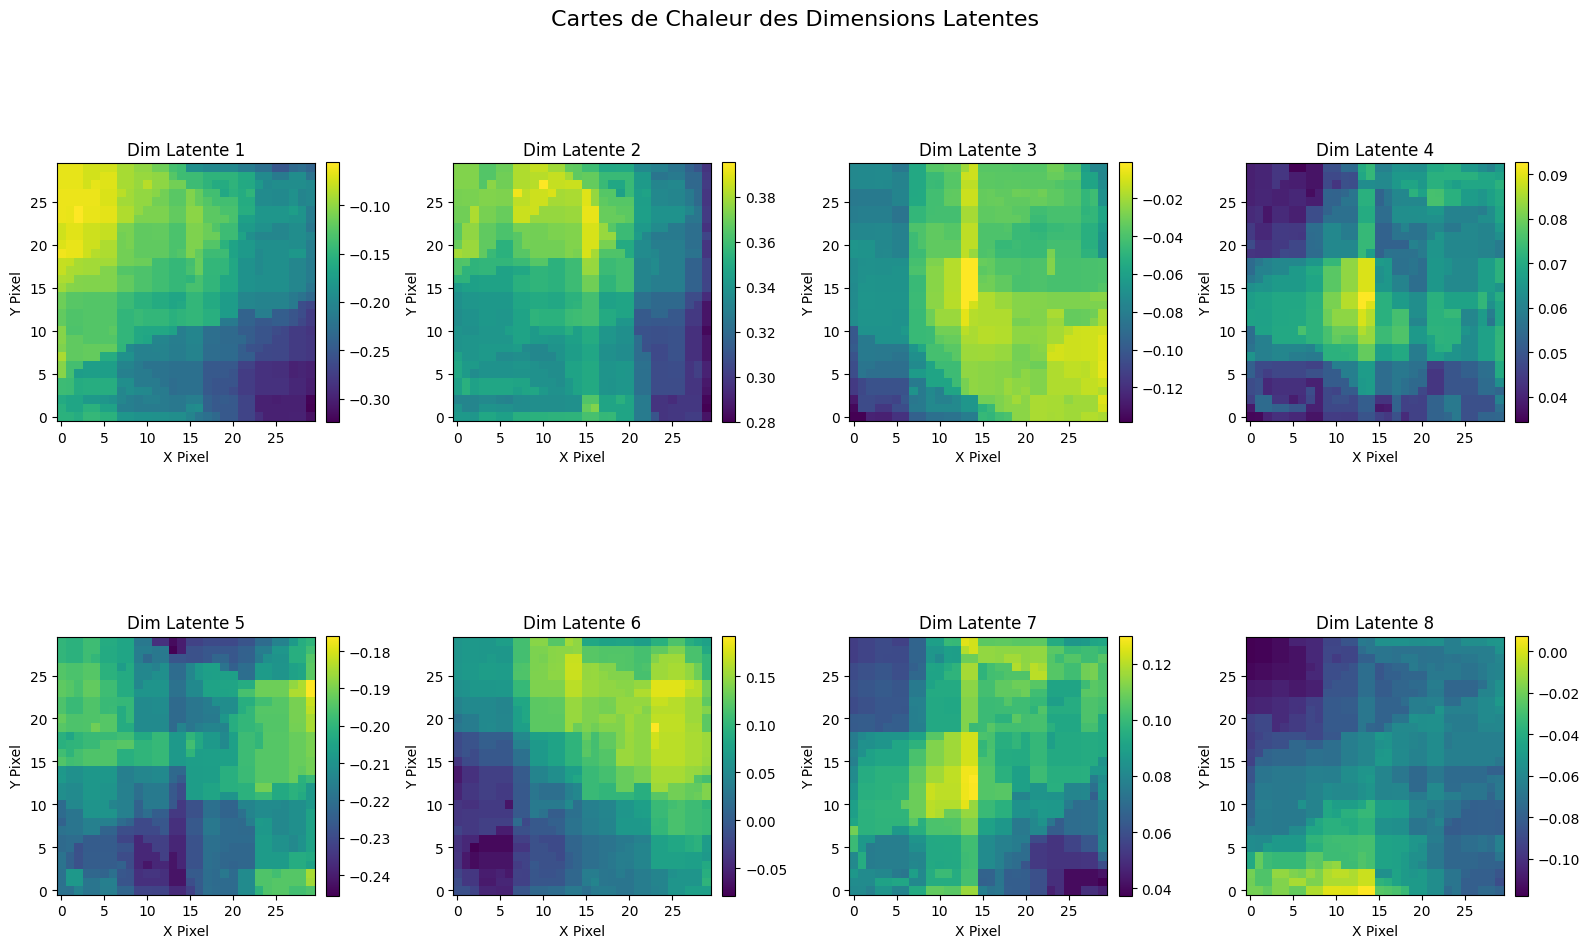

In [ ]:
# HEAT MAP

ncols = 4

# Calcule le nombre de lignes nécessaires
nrows = (latent_dim + ncols - 1) // ncols # Division entière avec plafond

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 5 * nrows))

# Aplatir le tableau d'axes pour itérer facilement, quelle que soit la forme (1D ou 2D)
axes = axes.flatten()

for i in range(latent_dim):
    ax = axes[i]
    # Afficher la i-ème dimension latente comme une image 2D
    im = ax.imshow(latent_map[:, :, i], cmap='viridis', origin='lower')
    ax.set_title(f'Dim Latente {i+1}')
    ax.set_xlabel('X Pixel')
    ax.set_ylabel('Y Pixel')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # Ajuster la barre de couleur

# Masquer les subplots vides si latent_dim n'est pas un multiple de ncols
for j in range(latent_dim, len(axes)):
    fig.delaxes(axes[j]) # Supprime les axes vides

plt.tight_layout()
plt.suptitle('Cartes de Chaleur des Dimensions Latentes', y=1.02, fontsize=16) # y=1.02 pour laisser de la place au titre principal
plt.show()